In [20]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [63]:
df

,player1_name,player1_atprank,player1_games,player1_wins,player1_losses,player1_indoor_wins,player1_indoor_losses,player1_outdoor_wins,player1_outdoor_losses,player2_name,...,player2_outdoor_wins,player2_outdoor_losses,tournament_name,tournament_location,tournament_court,tournament_surface,match_date,match_odd_player1,match_odd_player2,winner_player1
0,Mager G.,67,59,24,35,3,7,21,28,Harrison R.,...,101,138,Delray Beach Open,Delray Beach,Outdoor,Hard,2021-01-07,2.00,1.72,1
1,Kwon S.W.,68,108,53,55,12,6,41,49,Korda S.,...,60,42,Delray Beach Open,Delray Beach,Outdoor,Hard,2021-01-07,2.00,1.72,0
2,Paul T.,14,204,111,93,19,13,92,80,Nam J.S.,...,0,3,Delray Beach Open,Delray Beach,Outdoor,Hard,2021-01-07,1.12,6.00,1
3,Travaglia S.,1024,81,27,54,5,12,22,42,Kecmanovic M.,...,95,87,Antalya Open,Antalya,Indoor,Hard,2021-01-07,2.62,1.44,1
4,Bellucci T.,915,380,179,201,22,24,157,177,Monteiro T.,...,60,91,Delray Beach Open,Delray Beach,Outdoor,Hard,2021-01-07,3.00,1.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7057,Tiafoe F.,10,303,158,145,24,23,134,122,Evans D.,...,106,111,Citi Open,Washington,Outdoor,Hard,2023-08-05,1.29,3.75,0
7058,Fritz T.,9,356,205,151,26,22,179,129,Griekspoor T.,...,40,36,Citi Open,Washington,Outdoor,Hard,2023-08-06,1.30,3.50,0
7059,Tsitsipas S.,5,390,264,126,49,32,215,94,De Minaur A.,...,131,92,Los Cabos Open,Los Cabos,Outdoor,Hard,2023-08-06,1.36,3.20,1
7060,Evans D.,30,251,124,127,18,16,106,111,Dimitrov G.,...,310,212,Citi Open,Washington,Outdoor,Hard,2023-08-06,3.20,1.36,1


In [21]:
df = df.dropna()
df.shape

(7029, 26)

In [26]:
from sklearn.model_selection import train_test_split

X = df[["player1_name", "player1_atprank", "player1_games", "player1_wins", "player1_losses", "player1_indoor_wins","player1_indoor_losses","player1_outdoor_wins","player1_outdoor_losses",
        "player2_name","player2_atprank", "player2_games", "player2_wins", "player2_losses", "player2_indoor_wins","player2_indoor_losses","player2_outdoor_wins","player2_outdoor_losses",
        "tournament_court",
        "match_date", "match_odd_player1", "match_odd_player2"]]
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)# shuffle=False)

In [27]:
from sklearn import preprocessing

col_to_drop = ["player1_name", "player2_name", "match_date"]
X_train_filtered = X_train.drop(col_to_drop,axis=1)
X_test_filtered = X_test.drop(col_to_drop,axis=1)

#normalisation is useless for gradientboostingclassifier

# we encode match_court to binary
X_train_filtered = X_train_filtered.apply(preprocessing.LabelEncoder().fit_transform)
X_test_filtered = X_test_filtered.apply(preprocessing.LabelEncoder().fit_transform)

In [28]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

#cross_val_score(dtree, X_test, y_test, cv=10)

y_predict = model.predict(X_test_filtered)

accuracy_score(y_predict, y_test)

0.6742532005689901

In [29]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")

We bet 1€ on all test matches
money spent: 1406 €
money won: 1376.9 €
TOTAL: -29.09999999999991 €


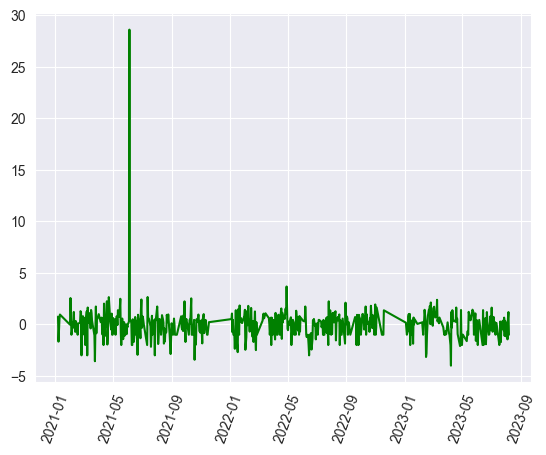

In [69]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [50]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)


print("We bet 1€ on all test matches where proba score is > 0.9")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[(df_roi["y_predict_proba"]>0.9) | (df_roi["y_predict_proba"]<0.1)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

We bet 1€ on all test matches where proba score is > 0.9
money spent: 115 €
money won: 149.66 €
TOTAL: 34.66 €
ROI: 130.13 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_12468\3627483195.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


In [48]:
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"] = y_test

df_roi["proba_bookmaker"] = 1/df_roi.match_odd_player1
df_roi[["player1_name","player2_name","y_predict", "y_test","y_predict_proba","proba_bookmaker"]]

,player1_name,player2_name,y_predict,y_test,y_predict_proba,proba_bookmaker
2770,Martinez P.,Londero J.I.,1,0,0.437371,0.666667
366,Kovalik J.,Bagnis F.,0,0,0.620270,0.381679
6232,Djere L.,Lestienne C.,1,1,0.190684,0.884956
2116,Lajovic D.,Kwon S.W.,0,0,0.575087,0.381679
3931,Bonzi B.,Tabilo A.,1,1,0.442326,0.714286
...,...,...,...,...,...,...
5079,Hurkacz H.,Rune H.,0,0,0.592032,0.653595
5108,Medvedev D.,Rublev A.,1,0,0.278431,0.751880
2095,Kukushkin M.,Duckworth J.,0,0,0.700377,0.333333
4106,Kozlov S.,Johnson S.,0,0,0.648973,0.333333


In [49]:
df_roi = df_roi.loc[df_roi.y_predict_proba > df_roi.proba_bookmaker]

money_invested=df_roi.shape[0]
money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")

money spent: 685 €
money won: 686.19 €
TOTAL: 1.19 €
ROI: 100.17 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_12468\4110373263.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


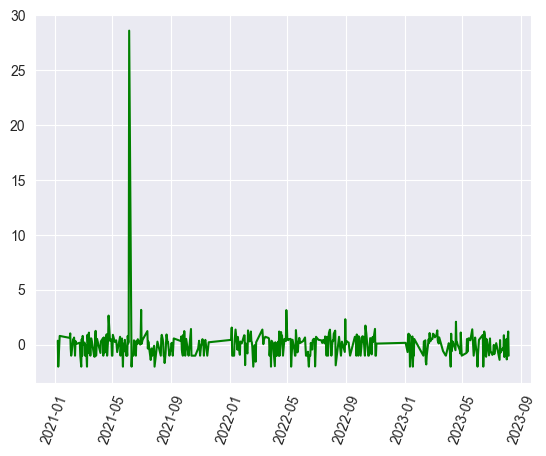

In [39]:
# on proba score > 0.9 (roi filtered from previous cell)
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [55]:
df_roi = df_roi.sort_values(by='match_odd_player1')
df_roi.head()

,player1_name,player1_atprank,player1_games,player1_wins,player1_losses,player1_indoor_wins,player1_indoor_losses,player1_outdoor_wins,player1_outdoor_losses,player2_name,...,player2_indoor_losses,player2_outdoor_wins,player2_outdoor_losses,tournament_court,match_date,match_odd_player1,match_odd_player2,y_predict_proba,y_predict,y_test
1524,Djokovic N.,2,1207,1012,195,146,42,866,153,Garin C.,...,13,88,74,Outdoor,2021-07-05,1.01,21.0,0.017127,1,1
3709,Nadal R.,2,1223,1017,206,76,40,941,166,Thompson J.,...,10,86,115,Outdoor,2022-05-23,1.01,23.0,0.015796,1,1
3783,Djokovic N.,2,1207,1012,195,146,42,866,153,Bedene A.,...,23,113,137,Outdoor,2022-05-27,1.01,21.0,0.011709,1,1
1139,Djokovic N.,2,1207,1012,195,146,42,866,153,Molcan A.,...,6,44,35,Outdoor,2021-05-29,1.02,19.0,0.031417,1,1
1141,Tsitsipas S.,5,390,264,126,49,32,215,94,Chardy J.,...,48,245,254,Outdoor,2021-05-30,1.02,17.0,0.060927,1,1


In [41]:
#Ici on veut conserver uniquement les jouerus qui ont fait déja au moins 6 matchs en pro
df_roi= df_roi.loc[(df_roi["player1_games"]>6) & (df_roi["player2_games"]>6)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

money spent: 655 €
money won: 649.93 €
TOTAL: -5.07 €
ROI: 99.23 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_12468\29534856.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


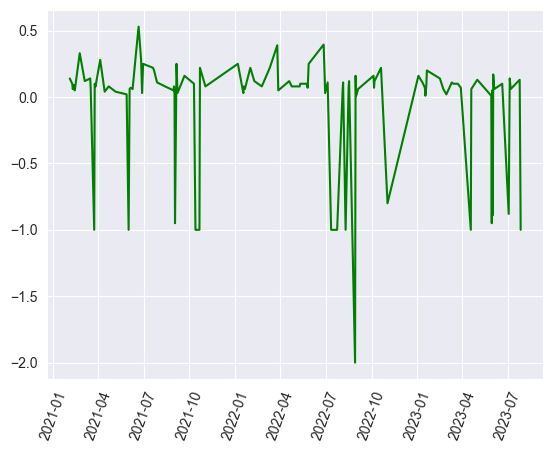

In [11]:
# on proba score > 0.9 (roi filtered from previous cell)
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [41]:
# Se limiter au joueur ayant un nombre minimum de parties augmentent grandement la fiabilité du modèle...
# ... mais réduit drastiquement le nombre de match à parier

In [45]:
# let's test this on prod 
from generate_x_prod import *
atpurl = "https://www.atptour.com/en/scores/current/us-open/560/daily-schedule"
playersfile="./data/players.csv"
tournamentsfile="./data/tournaments.csv"
outputfile ="./data/x_prod.csv"
generate_x_prod(playersfile, tournamentsfile, atpurl, outputfile)


In [46]:
# let's remove na player 
x_prod = pd.read_csv(outputfile)
x_prod = x_prod.dropna(subset=["player1_ATPRank", "player2_ATPRank"])
x_prod.to_csv(outputfile,index=False)

#let's add odds
#to better look for name
x_prod[["player1_name","player2_name"]]

,player1_name,player2_name
2,Anderson K.,Machac T.
4,Couacaud E.,Kukushkin M.
7,Mochizuki S.,Cazaux A.
21,Zeppieri G.,Giannessi A.
23,Klein L.,Marterer M.
29,Nava E.,Vavassori A.
33,Millman J.,Travaglia S.
36,Svajda Z.,Pospisil V.
38,Spizzirri E.,Kovacevic A.
39,Daniel T.,Hong S.


In [14]:
x_prod = pd.read_csv("./data/x_prod_odds.csv")
X = x_prod[["player1_name", "player1_atprank", "player1_games", "player1_wins", "player1_losses", "player1_indoor_wins","player1_indoor_losses","player1_outdoor_wins","player1_outdoor_losses",
        "player2_name","player2_atprank", "player2_games", "player2_wins", "player2_losses", "player2_indoor_wins","player2_indoor_losses","player2_outdoor_wins","player2_outdoor_losses",
        "tournament_court",
        "match_date", "match_odd_player1", "match_odd_player2"]]

X_filtered = X.drop(["player1_name","player2_name","match_date"],axis=1)
X_filtered = X_filtered.apply(preprocessing.LabelEncoder().fit_transform)
y_predict = model.predict(X_filtered)
y_predict_proba = model.predict_proba(X_filtered)

df_roi = X.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict

df_roi["proba_bookmaker"] = 1/df_roi.match_odd_player1
df_roi[["player1_name","player2_name","y_predict","y_predict_proba","proba_bookmaker"]]

,player1_name,player2_name,y_predict,y_predict_proba,proba_bookmaker
0,Anderson K.,Machac T.,0,0.741068,0.465116
1,Couacaud E.,Kukushkin M.,0,0.971138,0.980392
2,Mochizuki S.,Cazaux A.,0,0.951173,0.281690
3,Klein L.,Marterer M.,0,0.635334,0.500000
4,Nava E.,Vavassori A.,0,0.639064,0.671141
5,Millman J.,Travaglia S.,0,0.633590,0.621118
6,Svajda Z.,Pospisil V.,0,0.602934,0.602410
7,Spizzirri E.,Kovacevic A.,0,0.931499,0.298507
8,Daniel T.,Hong S.,1,0.074366,0.862069
9,Gaston H.,Shimizu Y.,1,0.082760,0.694444


In [52]:
df_roi_filtered= df_roi.loc[(df_roi["player1_games"]>6) & (df_roi["player2_games"]>6)]
df_roi_filtered[["player1_name","player2_name","y_predict","y_predict_proba",1/"match_odd_player1"]]

,player1_name,player2_name,y_predict,y_predict_proba
0,Anderson K.,Machac T.,0,0.776377
1,Couacaud E.,Kukushkin M.,0,0.992808
3,Klein L.,Marterer M.,0,0.684782
4,Nava E.,Vavassori A.,0,0.858859
5,Millman J.,Travaglia S.,0,0.815371
6,Svajda Z.,Pospisil V.,0,0.693223
